In [14]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
import glob
import os

# in colab
from google import colab
colab.drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


대상 이미지 루트경로 지정

In [15]:
root_path = "/content/drive/MyDrive/Colab Notebooks/01_rock_scissor_paper/"

## 이미지 전처리(28x28 리사이즈)

In [20]:
def resize_images(img_path):
    images = glob.glob(img_path + "/*.jpg")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28, 28)
    affect = 0
    for img in images:
        old_img = Image.open(img)
        if old_img.size == target_size:  # 이미 기 리사이징 된 이미지는 무시한다
            continue

        new_img=old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, "JPEG")
        affect += 1

    print(f"({affect}/{len(images)}) images resized.")

# 가위 이미지
image_dir_path = root_path + "scissor"
resize_images(image_dir_path)
# 바위 이미지
image_dir_path = root_path + "rock"
resize_images(image_dir_path)
# 보 이미지
image_dir_path = root_path + "paper"
resize_images(image_dir_path)

(0/100) images resized.
(0/100) images resized.
(0/100) images resized.


## 데이터 라벨링 & 로드

In [21]:
import numpy as np

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = root_path
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


## 라벨 데이터 확인

라벨:  1


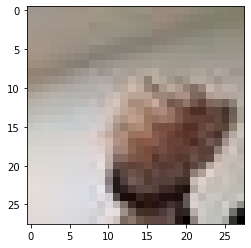

In [23]:
import matplotlib.pyplot as plt

plt.imshow(x_train[150])
print('라벨: ', y_train[150])

## 모델 작성

In [34]:
tf.random.set_seed(36)  # 랜덤 시드 설정

In [35]:
n_channel_1=32  # 특징
n_channel_2=64
n_dense=64
n_train_epoch=12

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))  # 차원압축
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_6 (Dense)             (None, 64)               

## 모델 학습시키기

In [36]:
x_train_reshaped=x_train_norm.reshape( -1, 28, 28, 3)
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_reshaped, y_train, epochs=n_train_epoch)

Epoch 1/12
10/10 [==============================] - 1s 37ms/step - loss: 1.0926 - accuracy: 0.3800
Epoch 2/12
10/10 [==============================] - 0s 37ms/step - loss: 1.0430 - accuracy: 0.4700
Epoch 3/12
10/10 [==============================] - 0s 34ms/step - loss: 0.9489 - accuracy: 0.6267
Epoch 4/12
10/10 [==============================] - 0s 38ms/step - loss: 0.8647 - accuracy: 0.5933
Epoch 5/12
10/10 [==============================] - 0s 35ms/step - loss: 0.7815 - accuracy: 0.6467
Epoch 6/12
10/10 [==============================] - 0s 34ms/step - loss: 0.6274 - accuracy: 0.7900
Epoch 7/12
10/10 [==============================] - 0s 40ms/step - loss: 0.5175 - accuracy: 0.8300
Epoch 8/12
10/10 [==============================] - 0s 35ms/step - loss: 0.4014 - accuracy: 0.9033
Epoch 9/12
10/10 [==============================] - 0s 36ms/step - loss: 0.3171 - accuracy: 0.9333
Epoch 10/12
10/10 [==============================] - 0s 41ms/step - loss: 0.2920 - accuracy: 0.9100
Epoch 11/

## 모델 검증

In [37]:
image_dir_path = root_path + "test"
(x_test, y_test) = load_data(image_dir_path)
x_test_norm = x_test / 255.0
x_test_reshaped = x_test_norm.reshape( -1, 28, 28, 3)

print("x_train shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_test.shape))

test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)
10/10 - 0s - loss: 0.1503 - accuracy: 0.9667 - 245ms/epoch - 25ms/step
test_loss: 0.15034018456935883 
test_accuracy: 0.9666666388511658


## 오차데이터 시각화해서 확인해보기

예측확률분포: [0.28728628 0.30671948 0.40599418]
라벨: 1, 예측결과: 2


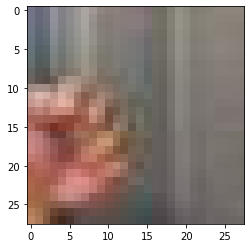

예측확률분포: [0.11094669 0.17053722 0.7185161 ]
라벨: 0, 예측결과: 2


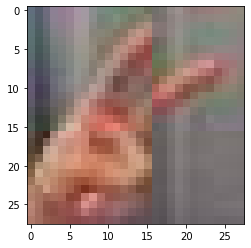

예측확률분포: [0.1721453  0.17602882 0.6518259 ]
라벨: 0, 예측결과: 2


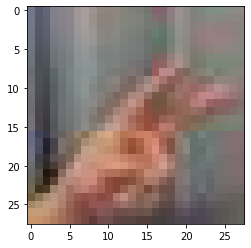

예측확률분포: [0.22930786 0.3557009  0.41499123]
라벨: 1, 예측결과: 2


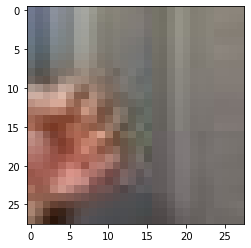

예측확률분포: [0.11094669 0.17053722 0.7185161 ]
라벨: 0, 예측결과: 2


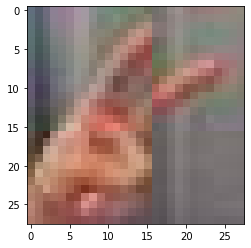

In [39]:
predicted_result = model.predict(x_test_reshaped)  # model이 추론한 확률값.
predicted_labels = np.argmax(predicted_result, axis=1)

import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다.
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()